In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from scipy import stats
import chardet
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Step 1: Detect encoding and read data
with open('/content/customer_booking.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(f"Detected Encoding: {result['encoding']}")

# Read the dataset with detected encoding
data = pd.read_csv('/content/customer_booking.csv', encoding=result['encoding'])

Detected Encoding: ISO-8859-1


In [2]:
# Step 2: Basic Data Information and EDA
print(data.describe())
print(data.info())



       num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50000.000000          50000.000000           50000.000000   
mean              0.668780              0.296960               0.427140   
std               0.470657              0.456923               0.494668   
min               0.000000              0.000000               0.000000   
25%

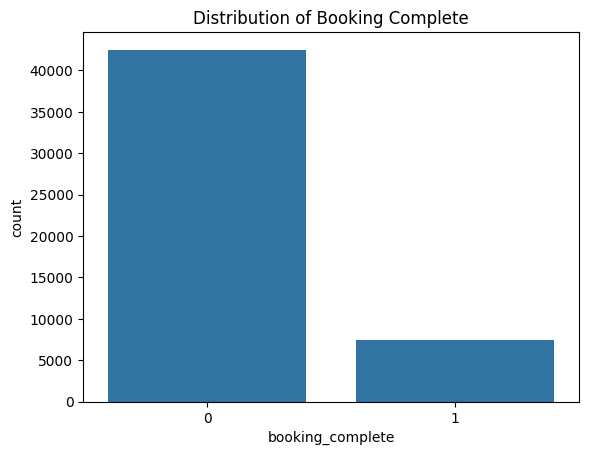

In [3]:
# Step 3: Data Visualization
# Target variable distribution
sns.countplot(x='booking_complete', data=data)
plt.title('Distribution of Booking Complete')
plt.show()

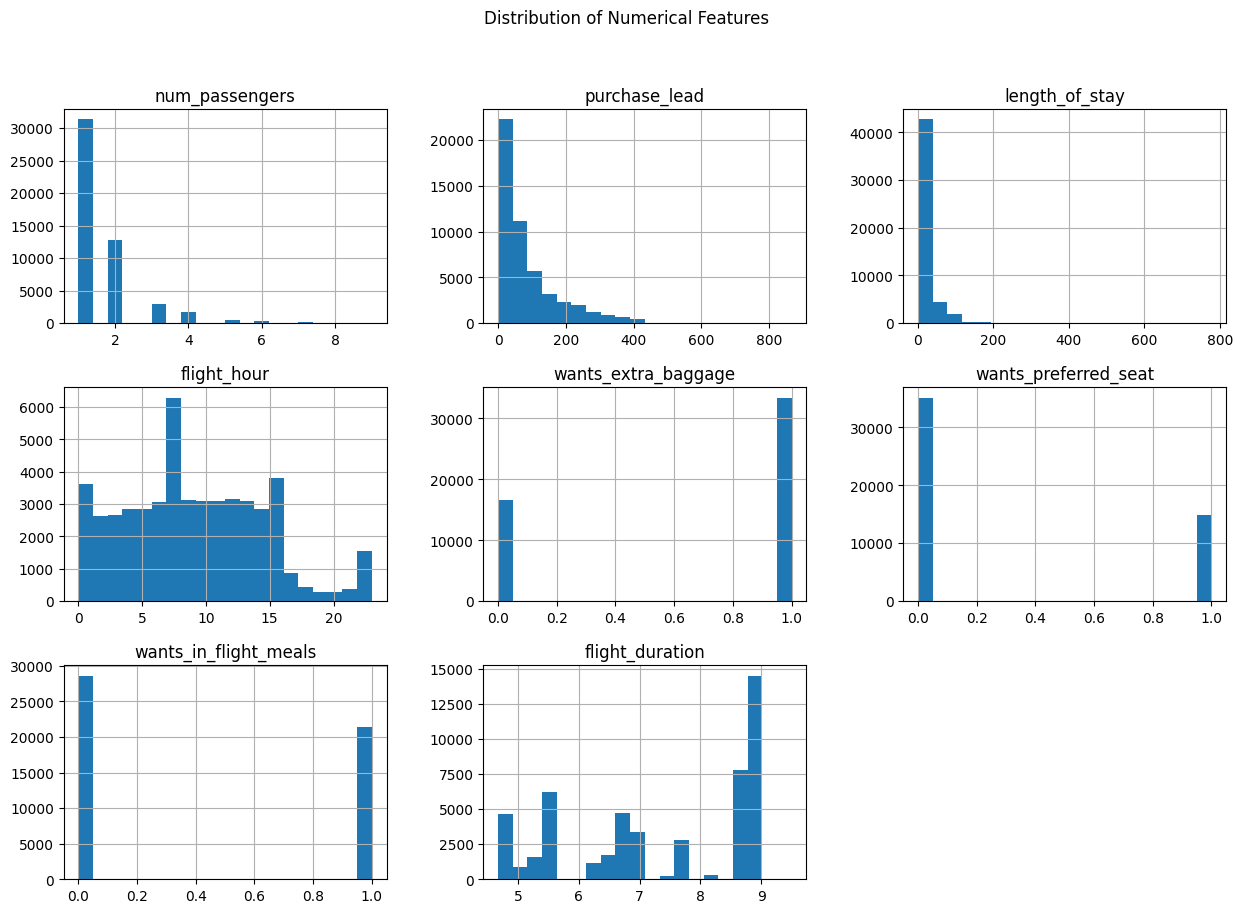

In [4]:
# Numerical features distribution
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
                  'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
                  'flight_duration']
data[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

In [5]:
# Step 4: Handling Outliers in Numerical Columns
z_scores = np.abs(stats.zscore(data[numerical_cols]))
data_clean = data[(z_scores < 3).all(axis=1)]  # Retain rows within 3 standard deviations


In [6]:
# Step 5: Log Transformation of Skewed Columns
data_original = data_clean[['purchase_lead', 'length_of_stay']].copy()
data_clean['purchase_lead'] = np.log1p(data_clean['purchase_lead'])
data_clean['length_of_stay'] = np.log1p(data_clean['length_of_stay'])


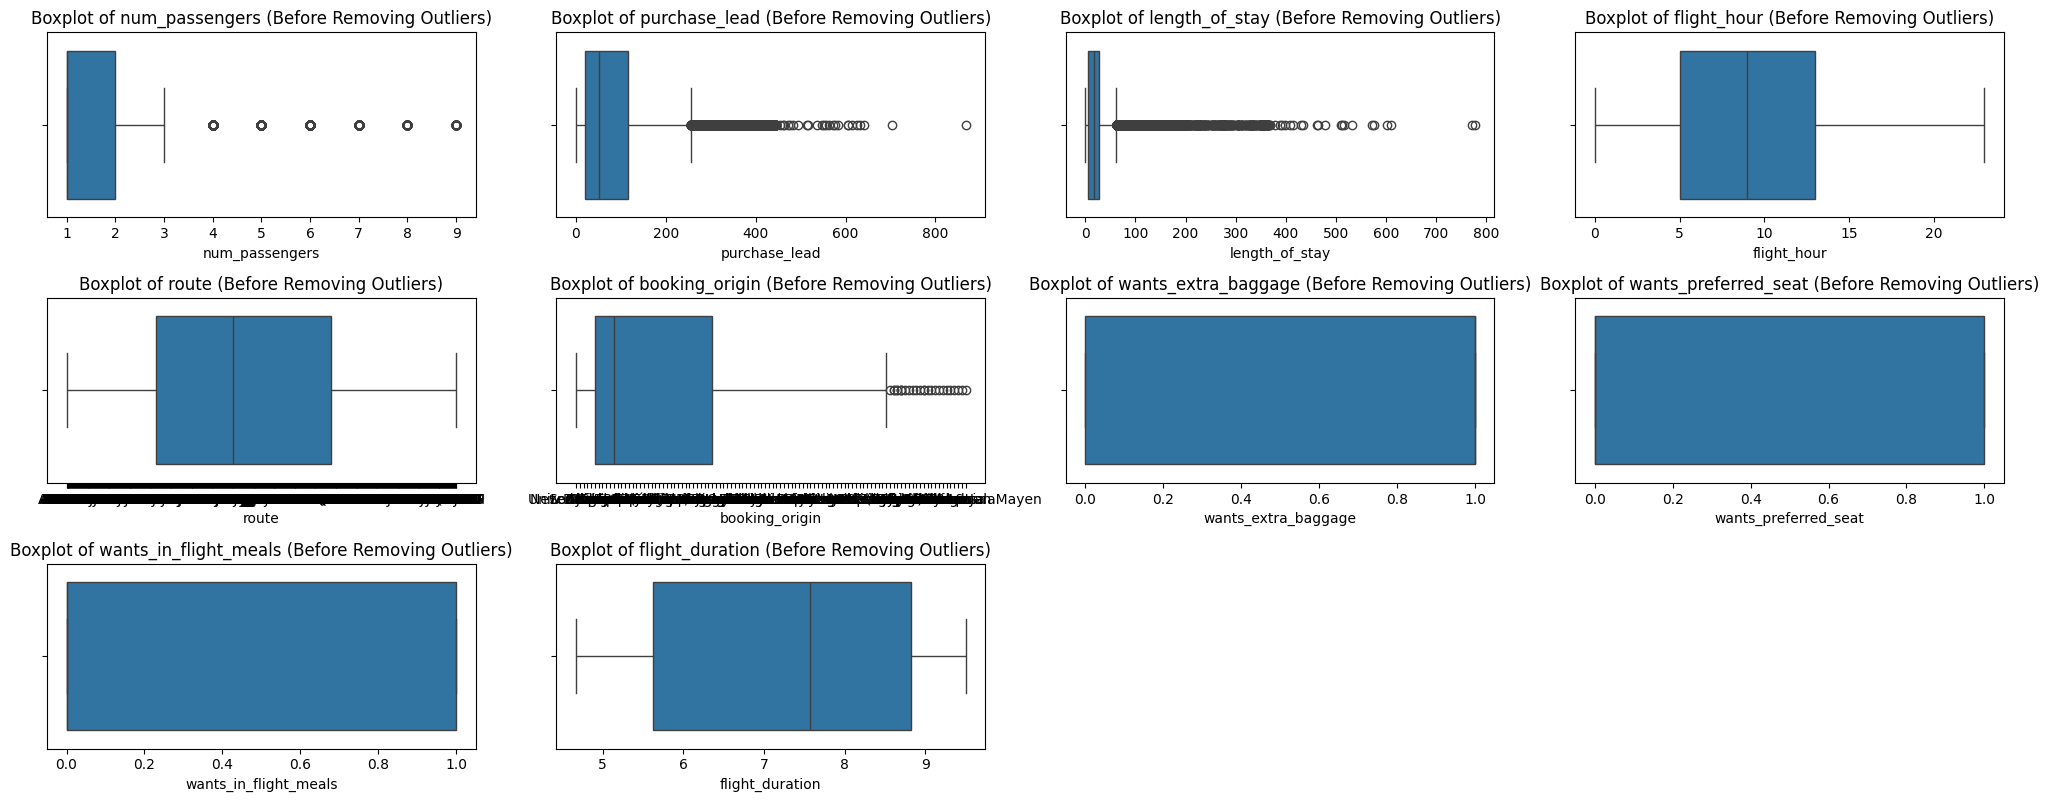

In [37]:

# 2. Boxplots for numerical features after removing outliers
plt.figure(figsize=(20, 13))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col} (Before Removing Outliers)')
plt.tight_layout()
plt.show()

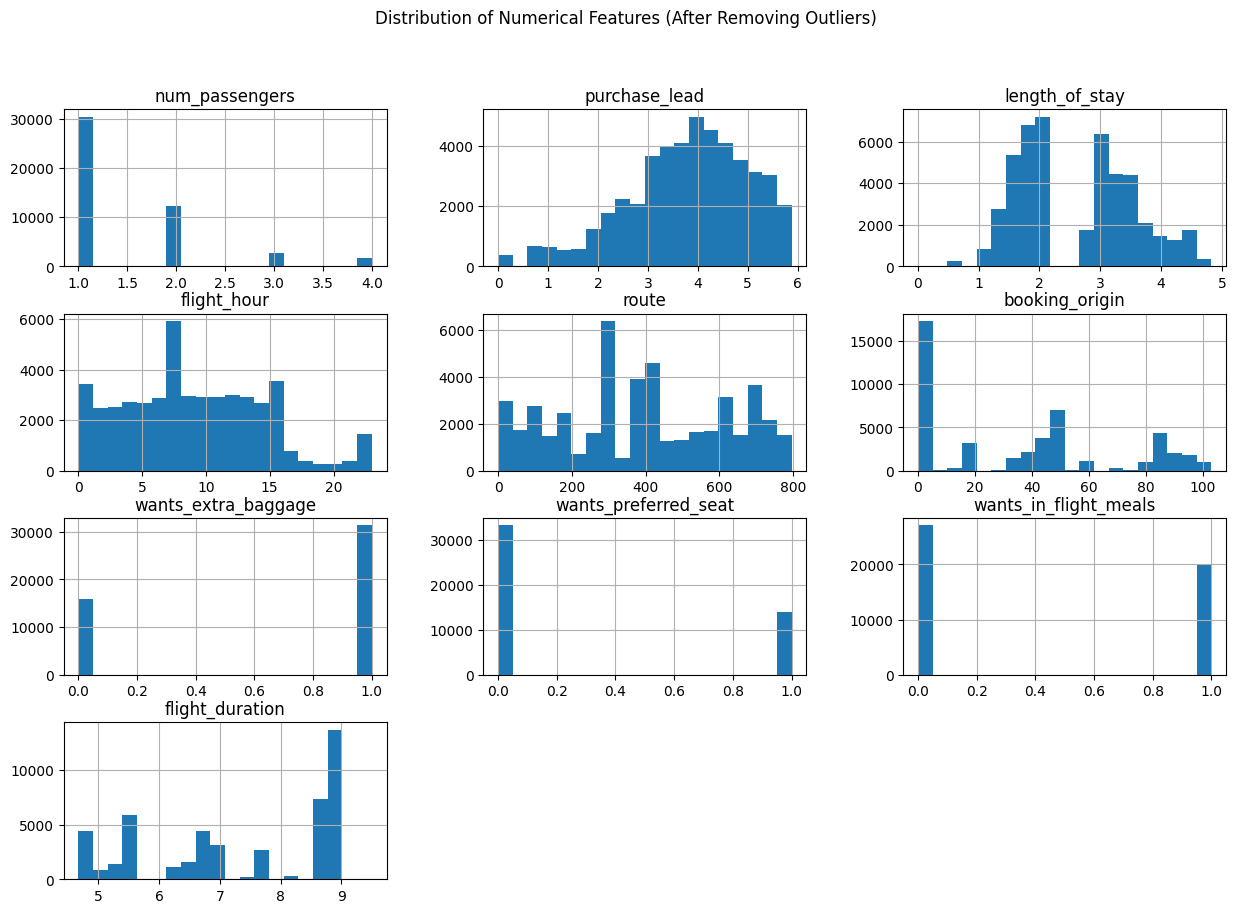

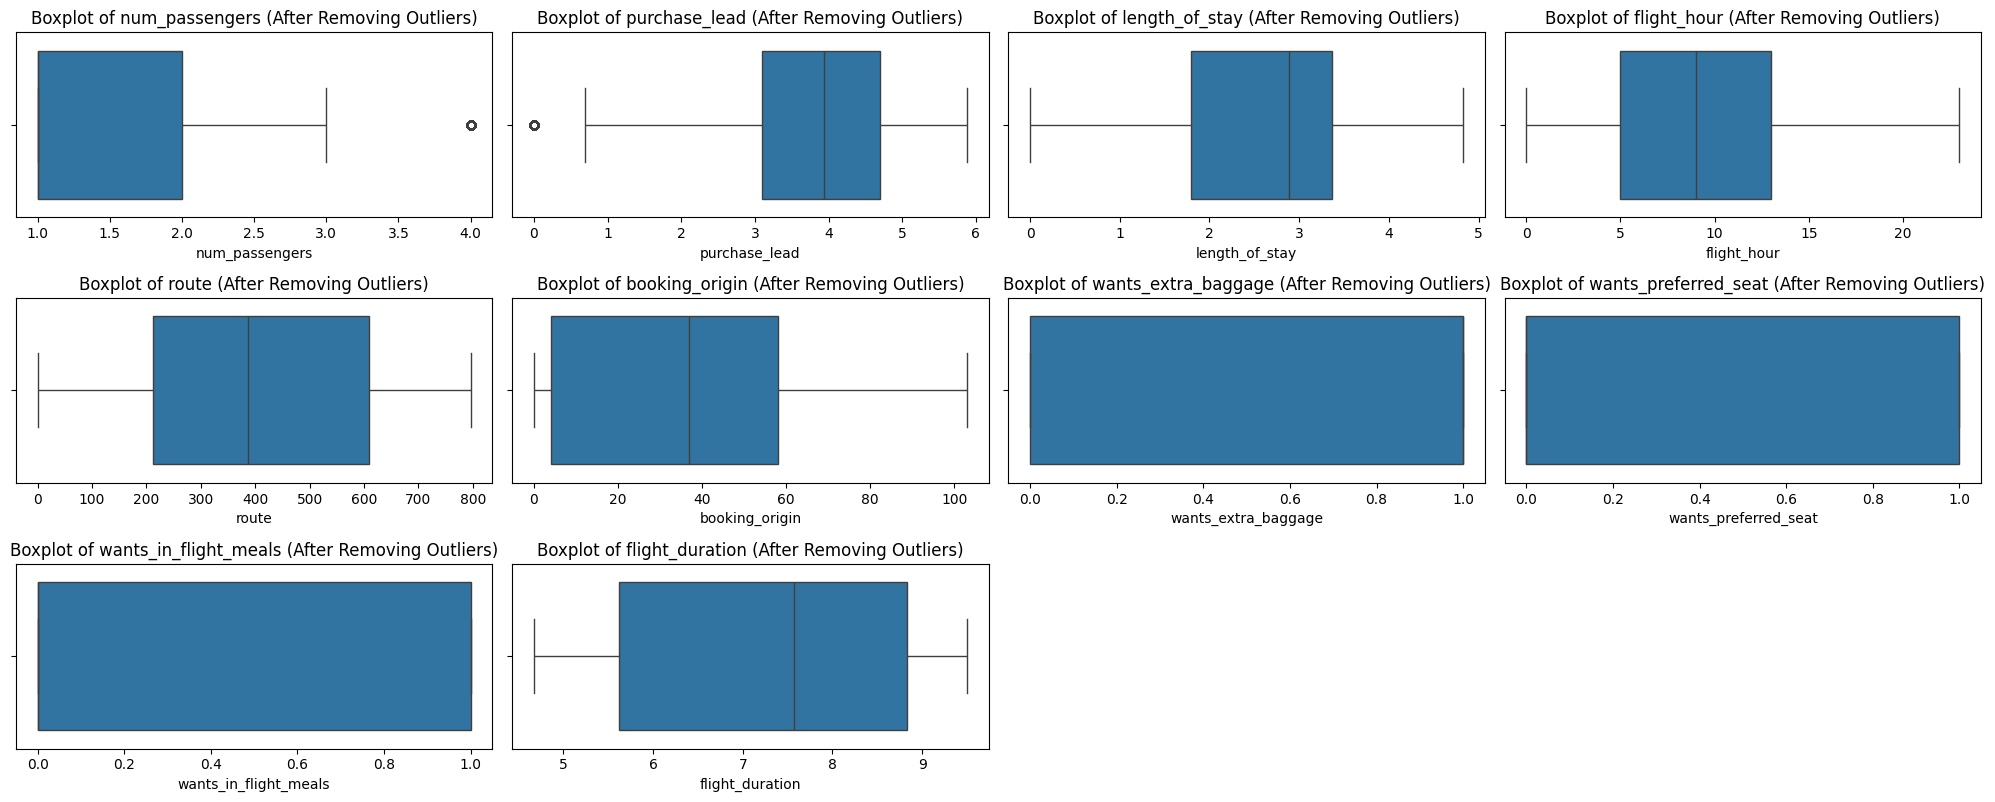

In [27]:
# Numerical features distribution (histograms) after removing outliers
data_clean[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features (After Removing Outliers)')
plt.show()

# 2. Boxplots for numerical features after removing outliers
plt.figure(figsize=(20, 13))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=data_clean[col])
    plt.title(f'Boxplot of {col} (After Removing Outliers)')
plt.tight_layout()
plt.show()

In [7]:
# Step 6: Categorical Encoding
# Columns to be encoded
categorical_cols = ['sales_channel', 'trip_type', 'flight_day']
label_cols = ['route', 'booking_origin']

# Apply One-Hot Encoding for columns with fewer unique values
data_clean = pd.get_dummies(data_clean, columns=categorical_cols)

# Apply Label Encoding for columns with potentially high cardinality
label_encoder = LabelEncoder()
for col in label_cols:
    data_clean[col] = label_encoder.fit_transform(data_clean[col])

In [8]:
from statsmodels.tools.tools import add_constant

# Step 7: Check for multicollinearity (Variance Inflation Factor - VIF)
# Select numerical columns + newly encoded columns for correlation check
numerical_and_encoded_cols = data_clean.select_dtypes(include=[np.number]).columns.tolist()
X = data_clean[numerical_and_encoded_cols]
X_with_const = add_constant(X)  # Add constant to the feature set
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)


                 Variable        VIF
0                   const  56.545153
1          num_passengers   1.103007
2           purchase_lead   1.074219
3          length_of_stay   1.239272
4             flight_hour   1.006573
5                   route   1.038855
6          booking_origin   1.136033
7     wants_extra_baggage   1.198374
8    wants_preferred_seat   1.148142
9   wants_in_flight_meals   1.164105
10        flight_duration   1.155567
11       booking_complete   1.040850


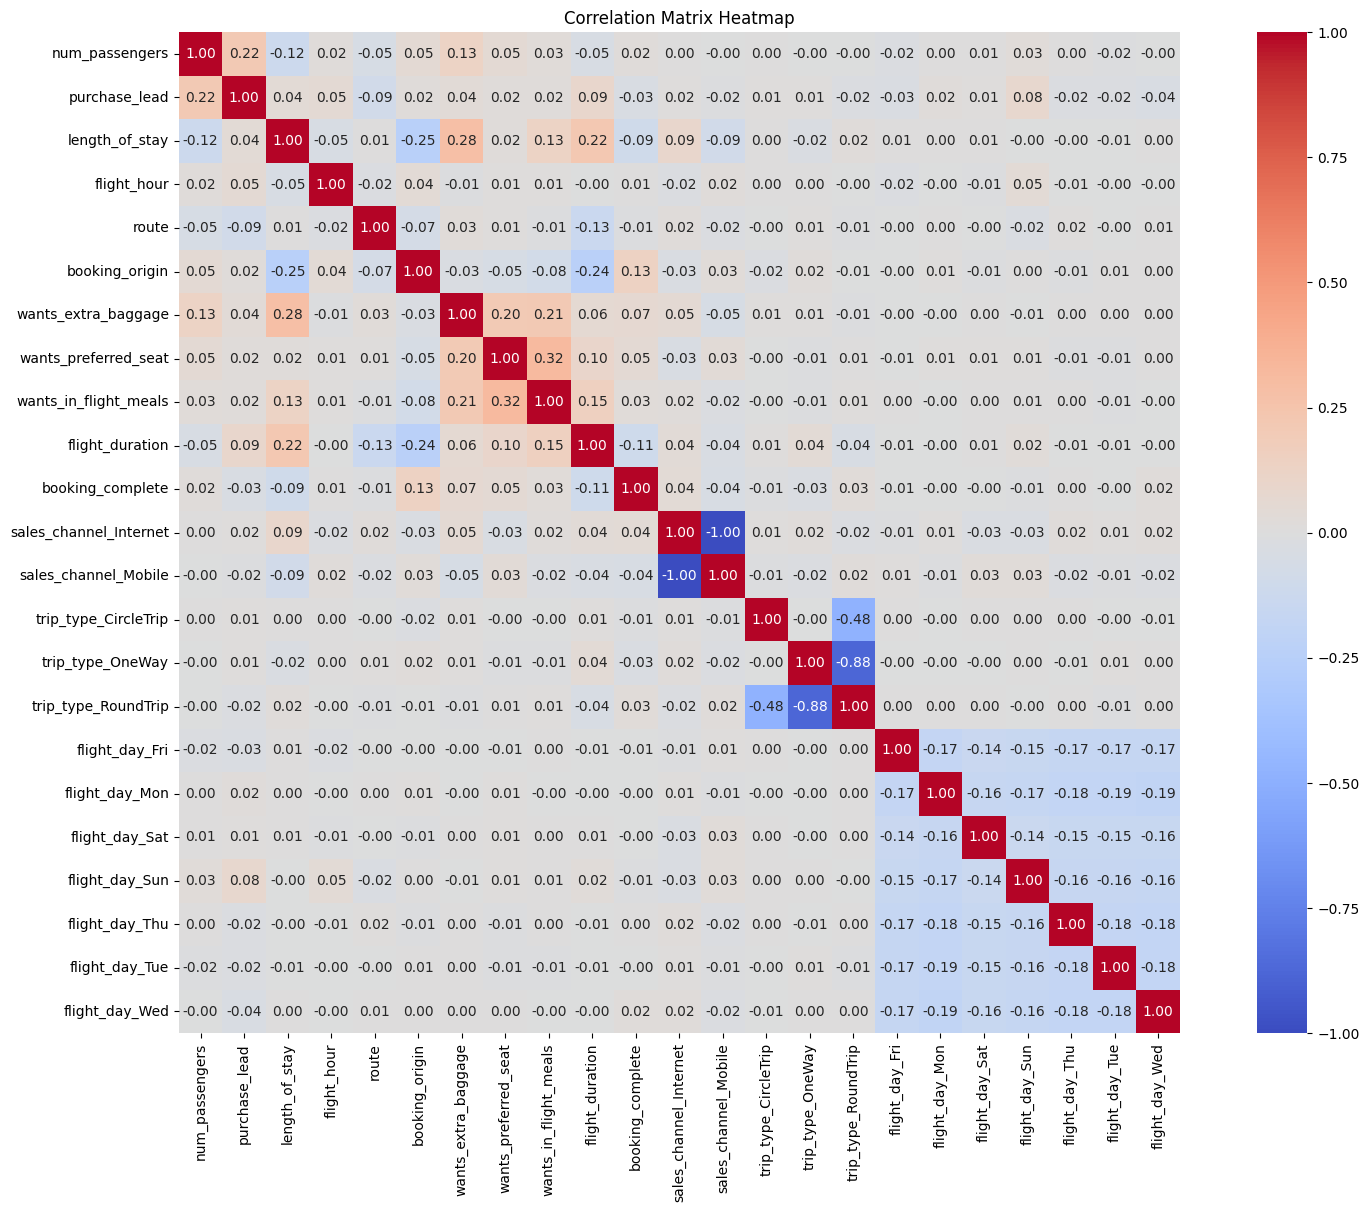

In [9]:


# Step 8: Correlation Heatmap for Encoded Dataset
correlation_matrix = data_clean.corr()
plt.figure(figsize=(20, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()



In [10]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47137 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_passengers          47137 non-null  int64  
 1   purchase_lead           47137 non-null  float64
 2   length_of_stay          47137 non-null  float64
 3   flight_hour             47137 non-null  int64  
 4   route                   47137 non-null  int64  
 5   booking_origin          47137 non-null  int64  
 6   wants_extra_baggage     47137 non-null  int64  
 7   wants_preferred_seat    47137 non-null  int64  
 8   wants_in_flight_meals   47137 non-null  int64  
 9   flight_duration         47137 non-null  float64
 10  booking_complete        47137 non-null  int64  
 11  sales_channel_Internet  47137 non-null  bool   
 12  sales_channel_Mobile    47137 non-null  bool   
 13  trip_type_CircleTrip    47137 non-null  bool   
 14  trip_type_OneWay        47137 non-null  boo

In [11]:
print(data_clean.columns)


Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'route', 'booking_origin', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration',
       'booking_complete', 'sales_channel_Internet', 'sales_channel_Mobile',
       'trip_type_CircleTrip', 'trip_type_OneWay', 'trip_type_RoundTrip',
       'flight_day_Fri', 'flight_day_Mon', 'flight_day_Sat', 'flight_day_Sun',
       'flight_day_Thu', 'flight_day_Tue', 'flight_day_Wed'],
      dtype='object')


In [12]:
X = data_clean.drop(columns=['booking_complete'])  # Features
y = data_clean['booking_complete']  # Target


In [13]:
# Ensure the column is not dropped or renamed
X = data_clean.drop(columns=['booking_complete'])
y = data_clean['booking_complete']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model_pipeline.fit(X_train, y_train)
print("Model Score:", model_pipeline.score(X_test, y_test))


Model Score: 0.8373992363173526


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model_pipeline.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91      8000
           1       0.34      0.07      0.12      1428

    accuracy                           0.84      9428
   macro avg       0.60      0.52      0.52      9428
weighted avg       0.78      0.84      0.79      9428

Confusion Matrix:
 [[7788  212]
 [1321  107]]


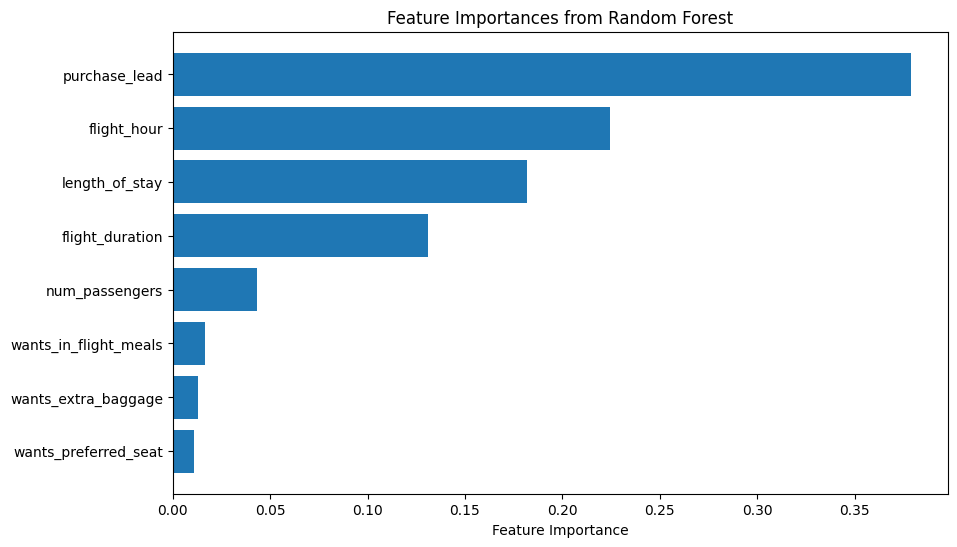

In [15]:
# Get the classifier from the pipeline
rf_classifier = model_pipeline.named_steps['classifier']

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get column names from the preprocessor step
feature_names = numerical_cols

# Sort feature importances
sorted_idx = feature_importances.argsort()

# Plotting feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importances from Random Forest")
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')


array([0.84949088, 0.82117098, 0.76715816, 0.38336692, 0.39461122])

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model
print("Best Model Score: ", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best Model Score:  0.85122914560484


In [18]:
from imblearn.over_sampling import SMOTE

# Define SMOTE instance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now train the model with the resampled data
model_pipeline.fit(X_train_resampled, y_train_resampled)
print("Model Score on resampled data:", model_pipeline.score(X_test, y_test))


Model Score on resampled data: 0.7628341111582521


In [19]:
# Adjusting the decision threshold
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
y_pred_adjusted = (y_pred_proba > 0.3).astype(int)  # Change the threshold

# Evaluate the adjusted predictions
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.88      0.64      0.74      8000
           1       0.21      0.52      0.30      1428

    accuracy                           0.62      9428
   macro avg       0.54      0.58      0.52      9428
weighted avg       0.78      0.62      0.67      9428



In [20]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47137 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_passengers          47137 non-null  int64  
 1   purchase_lead           47137 non-null  float64
 2   length_of_stay          47137 non-null  float64
 3   flight_hour             47137 non-null  int64  
 4   route                   47137 non-null  int64  
 5   booking_origin          47137 non-null  int64  
 6   wants_extra_baggage     47137 non-null  int64  
 7   wants_preferred_seat    47137 non-null  int64  
 8   wants_in_flight_meals   47137 non-null  int64  
 9   flight_duration         47137 non-null  float64
 10  sales_channel_Internet  47137 non-null  bool   
 11  sales_channel_Mobile    47137 non-null  bool   
 12  trip_type_CircleTrip    47137 non-null  bool   
 13  trip_type_OneWay        47137 non-null  bool   
 14  trip_type_RoundTrip     47137 non-null  boo

In [22]:
# Define features and target variable
X = data_clean.drop(columns=['booking_complete'])
y = data_clean['booking_complete']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline for numerical features
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols)
])

In [29]:
from xgboost import XGBClassifier

In [30]:
# Initialize SMOTE and XGBoost pipeline with the best scale_pos_weight found in tuning
best_weight = 5
smote_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=best_weight, random_state=42))
])


In [31]:
# Fit the model with SMOTE applied
smote_pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = smote_pipeline.predict(X_test)
y_prob = smote_pipeline.predict_proba(X_test)[:, 1]

In [32]:

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.60      0.73      8000
           1       0.25      0.77      0.38      1428

    accuracy                           0.62      9428
   macro avg       0.59      0.68      0.55      9428
weighted avg       0.83      0.62      0.68      9428

Confusion Matrix:
 [[4767 3233]
 [ 330 1098]]
Accuracy: 0.6220831565549427
F1 Score: 0.3813162007292933
AUC-ROC Score: 0.7431123511904763


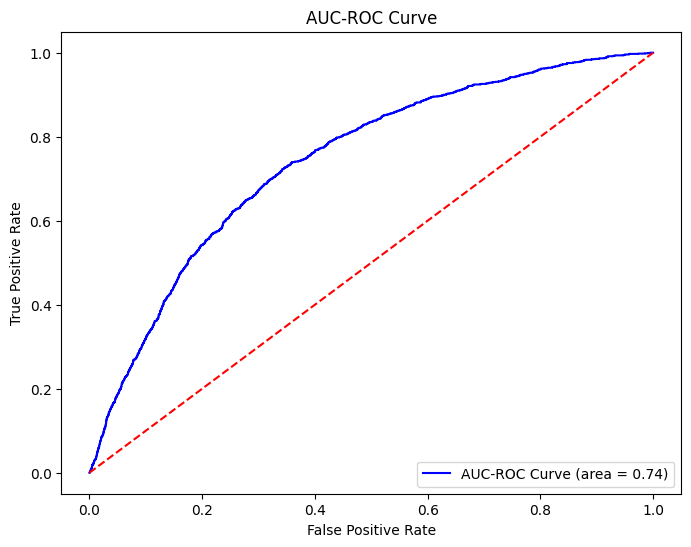

In [33]:
# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='AUC-ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [34]:
# Testing various thresholds and evaluating performance
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_adjusted = (y_prob > threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
    print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
    print("F1 Score:", f1_score(y_test, y_pred_adjusted))



Threshold: 0.3
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.42      0.58      8000
           1       0.21      0.88      0.34      1428

    accuracy                           0.49      9428
   macro avg       0.58      0.65      0.46      9428
weighted avg       0.84      0.49      0.54      9428

Confusion Matrix:
 [[3323 4677]
 [ 169 1259]]
Accuracy: 0.4859991514637251
F1 Score: 0.34193373166757196

Threshold: 0.4
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.51      0.66      8000
           1       0.23      0.83      0.36      1428

    accuracy                           0.56      9428
   macro avg       0.59      0.67      0.51      9428
weighted avg       0.84      0.56      0.62      9428

Confusion Matrix:
 [[4065 3935]
 [ 243 1185]]
Accuracy: 0.5568519304200255
F1 Score: 0.3619425778863775

Threshold: 0.5
Classification Report:
               pre

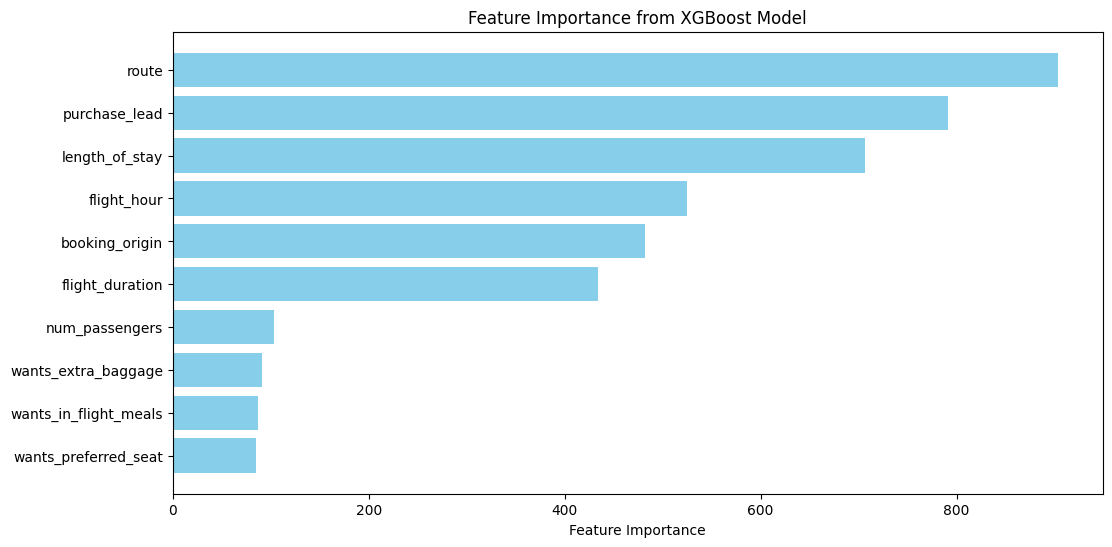

In [35]:
# Feature importance extraction
model = smote_pipeline.named_steps['classifier']  # Extract the XGBoost model from the pipeline
importance = model.get_booster().get_score(importance_type='weight')  # Get feature importance based on weight

# Convert the importance scores to a DataFrame for easier handling
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Map the feature names back to the original dataset column names
# Get the feature names after scaling (if applicable)
feature_names = numerical_cols  # these are the original feature names
importance_df['Original_Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])  # assuming features are named 'f0', 'f1', ...

# Sort the importance DataFrame by importance score
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Original_Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

In [36]:
# Display the top 10 important features
print("Top 10 Important Features:")
print(importance_df.head(10))

Top 10 Important Features:
  Feature  Importance       Original_Feature
4      f4       904.0                  route
1      f1       791.0          purchase_lead
2      f2       707.0         length_of_stay
3      f3       525.0            flight_hour
5      f5       482.0         booking_origin
9      f9       434.0        flight_duration
0      f0       103.0         num_passengers
6      f6        91.0    wants_extra_baggage
8      f8        87.0  wants_in_flight_meals
7      f7        85.0   wants_preferred_seat
